前回のarma_model_praでは、AIC理論を使い手動で最適係数を探索した。
だが、今回はAutoARIMAを使って機械学習的に自動で求めていく。

In [15]:
# ライブラリーの読み込み
from statistics import mean

import numpy as np
import pandas as pd
import pmdarima as pm
from matplotlib import pyplot as plt
from pmdarima import arima, datasets, model_selection, utils
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.seasonal import STL

# グラフのスタイルとサイズ
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = [12, 9]

In [10]:
# 1980/01 ~ 1994/08 までのオーストリアワインの月単位のワイン販売料
df = datasets.load_wineind()

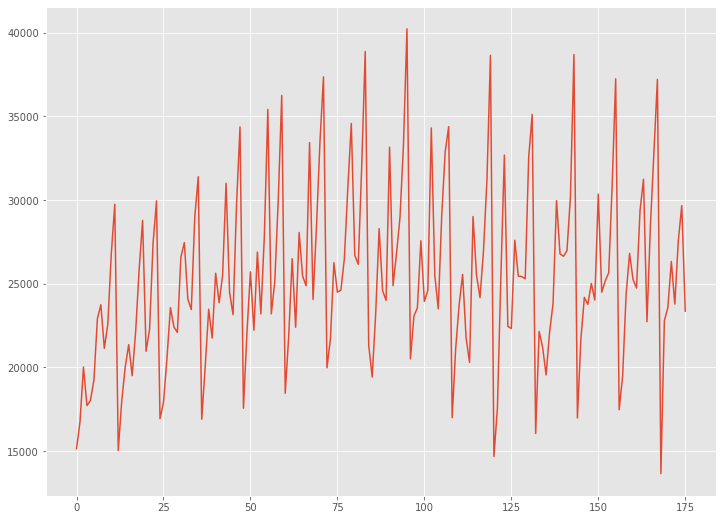

In [11]:
plt.plot(df)

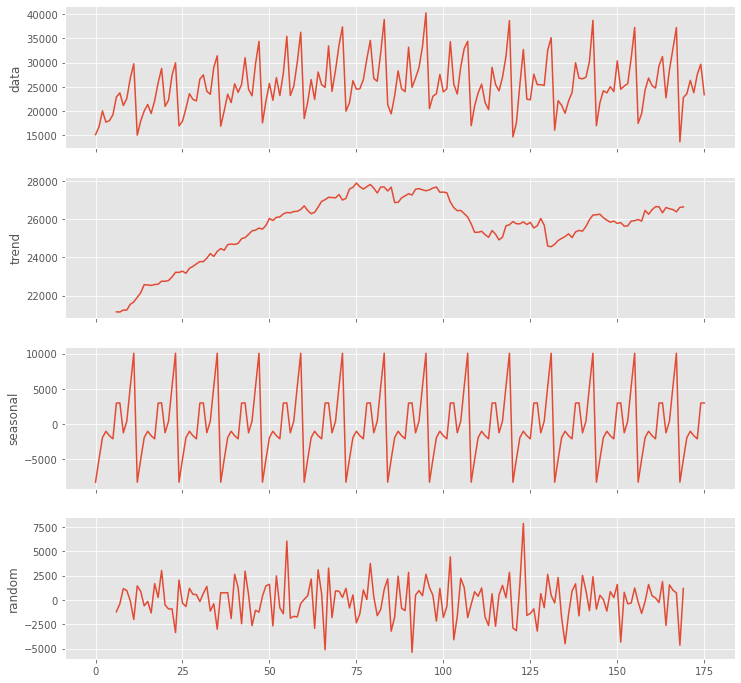

In [14]:
# 要素分解: additive:移動平均法を利用した分解(加法モデル)
result = utils.decomposed_plot(
    arima.decompose(df, "additive", m=12), figure_kwargs={"figsize": (12, 12)}
)

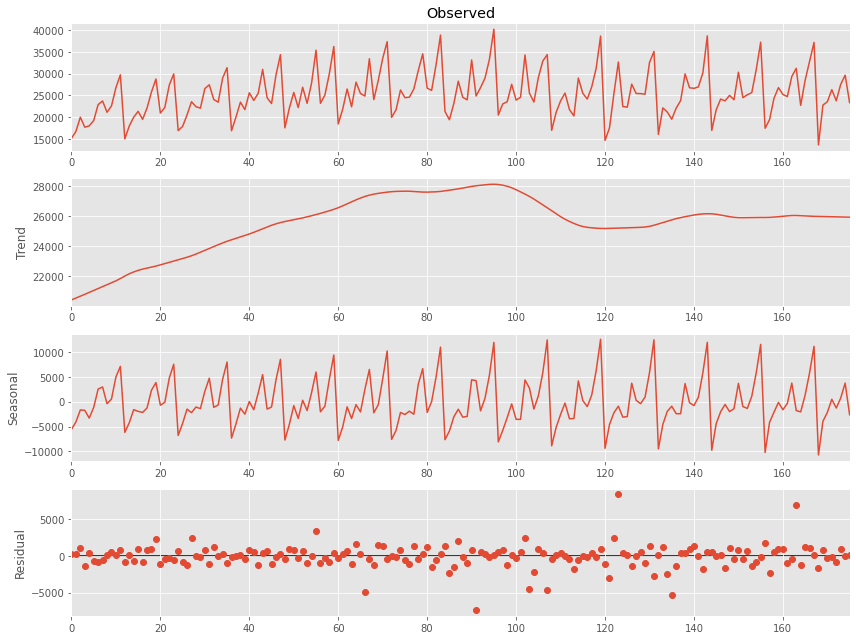

In [22]:
result_stl = STL(df, period=12, robust=True).fit()
result_stl.plot()
plt.show()

加法モデルのSeasonal(季節性,周期性)を見てみると定常っぽい<br>
だが、STL分解で見るとwindow=12で見ると定常だが、全体で見ると振幅自体が大きくなっている→トレンドがありそう

次に、自己相関と偏自己相関をコレログラムを見てみる

/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


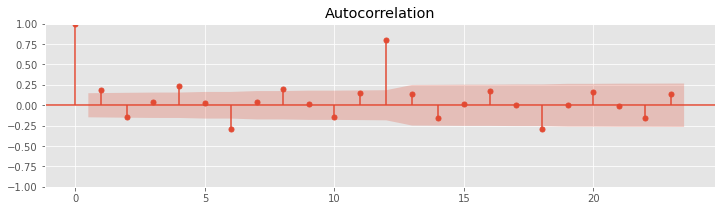

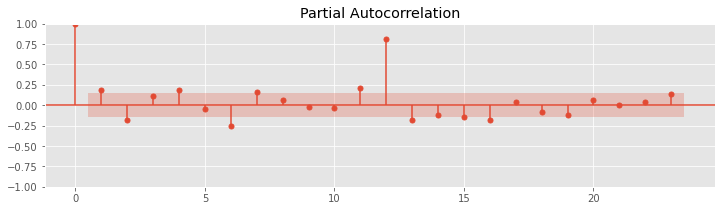

In [25]:
# グラフのサイズ変更
plt.rcParams["figure.figsize"] = [12, 3]
# 自己相関と偏自己相関(原系列)
utils.plot_acf(df, alpha=0.05)
utils.plot_pacf(df, alpha=0.05)

時系列データは基本的に、トレンド成分(急激な増減に影響する成分)があるので除去する必要がある<br>
この際に利用されるのが、差分化や対数変換をして成分除去をする。<br>
差分化では、何期前のデータとの差分を取るかわからない。→統計的有意差検定を実施する<br>
*今回のデータ原列系のコレログラムを見る限り綺麗な定常性が見えるため不必要と考える*

In [26]:
# 階差の次数の検討
print("d =", arima.ndiffs(df))  # d（階差）
print("D =", arima.nsdiffs(df, m=12))  # D（季節階差）

d = 1
D = 1


In [27]:
# 通常の階差処理を1回しさらに季節階差処理を1回
data_d1_d12 = pd.DataFrame(df).diff(1).diff(12).dropna()

In [29]:
data_d1_d12

,0
13,1352.0
14,-1252.0
15,3654.0
16,-2167.0
17,1419.0
...,...
171,305.0
172,-975.0
173,4271.0
174,-2510.0


/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/pmdarima/utils/visualization.py:220: FutureWarning: the 'unbiased'' keyword is deprecated, use 'adjusted' instead.
  res = tsaplots.plot_acf(


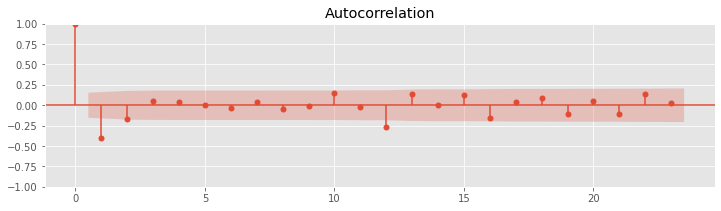

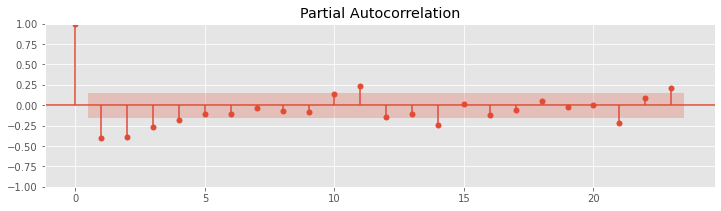

In [30]:
# グラフのサイズ変更
plt.rcParams["figure.figsize"] = [12, 3]
# 自己相関と偏自己相関
utils.plot_acf(data_d1_d12, alpha=0.05)
utils.plot_pacf(data_d1_d12, alpha=0.05)

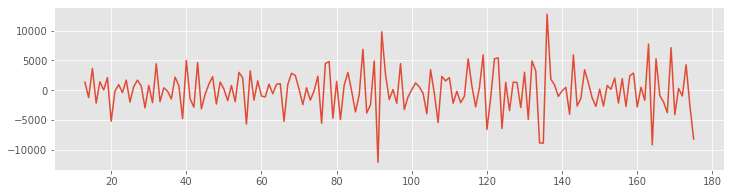

In [31]:
plt.plot(data_d1_d12)

In [40]:
# 最新3年間のデータをTest, それ以外をTrainとする。
# pm.auto_arimaで AR,I,MAそれぞれの適切なパラメータを決める(auto AIC)
train, test = model_selection.train_test_split(df, train_size=140)
arima_model = pm.auto_arima(
    train, seasonal=True, m=12, n_jobs=-1, trace=True, maxiter=10
)

/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=2722.388, Time=0.26 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2841.881, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2757.441, Time=0.17 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2748.415, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2839.907, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=2738.625, Time=0.12 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=2721.415, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=2783.069, Time=0.11 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=2721.700, Time=0.29 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=2723.699, Time=0.50 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=2730.711, Time=0.12 sec


/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,0,0)[12] intercept   : AIC=2717.391, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=2781.020, Time=0.06 sec


/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,0,0)[12] intercept   : AIC=2717.703, Time=0.30 sec
 ARIMA(2,1,1)(1,0,1)[12] intercept   : AIC=2718.629, Time=0.13 sec
 ARIMA(2,1,1)(0,0,1)[12] intercept   : AIC=2734.944, Time=0.14 sec
 ARIMA(2,1,1)(2,0,1)[12] intercept   : AIC=2719.457, Time=0.26 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2726.556, Time=0.10 sec


/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=2732.247, Time=0.26 sec
 ARIMA(3,1,1)(1,0,0)[12] intercept   : AIC=2718.895, Time=0.19 sec


/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,0)(1,0,0)[12] intercept   : AIC=2719.479, Time=0.25 sec
 ARIMA(3,1,2)(1,0,0)[12] intercept   : AIC=2721.306, Time=0.15 sec


/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(1,0,0)[12]             : AIC=2713.672, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[12]             : AIC=2777.605, Time=0.05 sec


/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(2,0,0)[12]             : AIC=2713.781, Time=0.28 sec
 ARIMA(2,1,1)(1,0,1)[12]             : AIC=2713.625, Time=0.16 sec
 ARIMA(2,1,1)(0,0,1)[12]             : AIC=2732.658, Time=0.19 sec
 ARIMA(2,1,1)(2,0,1)[12]             : AIC=2715.684, Time=0.41 sec
 ARIMA(2,1,1)(1,0,2)[12]             : AIC=2715.608, Time=0.28 sec
 ARIMA(2,1,1)(0,0,2)[12]             : AIC=2724.790, Time=0.34 sec
 ARIMA(2,1,1)(2,0,2)[12]             : AIC=2717.607, Time=0.28 sec
 ARIMA(1,1,1)(1,0,1)[12]             : AIC=2721.705, Time=0.09 sec
 ARIMA(2,1,0)(1,0,1)[12]             : AIC=2730.312, Time=0.25 sec
 ARIMA(3,1,1)(1,0,1)[12]             : AIC=2715.626, Time=0.15 sec
 ARIMA(2,1,2)(1,0,1)[12]             : AIC=2718.623, Time=0.15 sec
 ARIMA(1,1,0)(1,0,1)[12]             : AIC=2756.059, Time=0.07 sec
 ARIMA(1,1,2)(1,0,1)[12]             : AIC=2728.378, Time=0.10 sec
 ARIMA(3,1,0)(1,0,1)[12]             : AIC=2717.975, Time=0.16 sec
 ARIMA(3,1,2)(1,0,1)[12]             : AIC=2719.024, Time=0.16

In [48]:
test.shape

(36,)

# ARIMAモデルの自動構築: auto_arima(原系列を利用)

MAE:
2614.449038188962
MAPE(%):
9.788931021107135


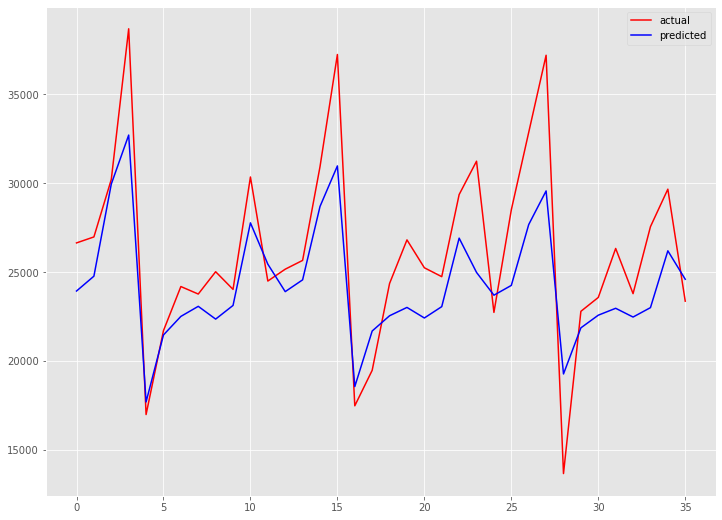

In [51]:
# グラフのサイズ変更
plt.rcParams["figure.figsize"] = [12, 9]
# 予測
preds, conf_int = arima_model.predict(n_periods=test.shape[0], return_conf_int=True)
# 予測精度
print("MAE:")
print(mean_absolute_error(test, preds))
print("MAPE(%):")
print(mean(abs(test - preds) / test) * 100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis, test, label="actual", color="r")
plt.plot(x_axis, preds, label="predicted", color="b")

plt.legend()
plt.show()

原系列を使った場合、精度はあまり良くない。<br>
これはトレンド成分が影響している可能性がある。<br>
私自身今回のデータでトレンド除去が必要ではないと書いたが、実際構築してみると予測精度が悪い。<br>
そのため、↓では先程求めた通常階差、季節階差の次数を使った階差行列を使った予測をしてみる。

In [54]:
# モデル構築（Auto ARIMA）
arima_model = pm.auto_arima(train, seasonal=True, m=12, d=1, D=1, n_jobs=-1, maxiter=10)
preds, conf_int = arima_model.predict(n_periods=test.shape[0], return_conf_int=True)

/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/pmdarima/arima/_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '
/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/isshintoyonaga/.anyenv/envs/pyenv/versions/anaconda3-2022.05/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal


MAE:
1879.1081485472912
MAPE(%):
7.405348638335722


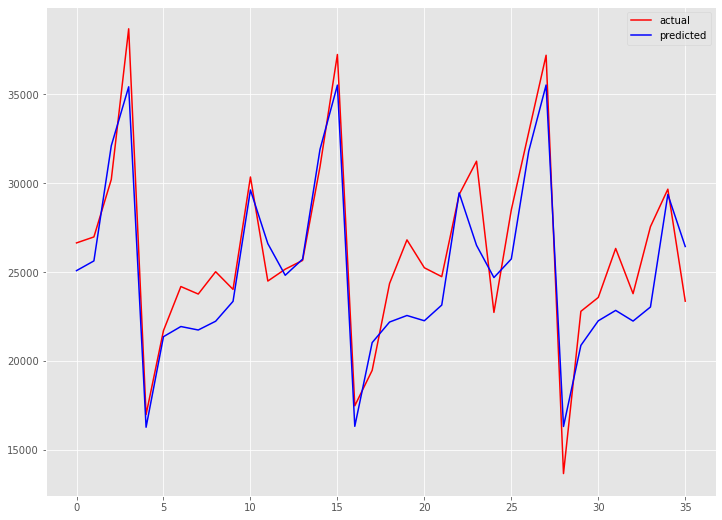

In [56]:
# 予測精度
print("MAE:")
print(mean_absolute_error(test, preds))
print("MAPE(%):")
print(mean(abs(test - preds) / test) * 100)
# 予測と実測の比較（グラフ）
x_axis = np.arange(preds.shape[0])
plt.plot(x_axis, test, label="actual", color="r")
plt.plot(x_axis, preds, label="predicted", color="b")

plt.legend()
plt.show()

# 予測精度は向上している。
# 全自動は便利ですが、実は手動と自動のハイブリッドが高精度になる傾向がある。